In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [4]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
df.shape

(284807, 31)

In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [ ]:
df.isna().sum()

In [8]:
df[["Time", "Amount"]].describe()

,Time,Amount
count,284807.000000,284807.000000
mean,94813.859575,88.349619
std,47488.145955,250.120109
min,0.000000,0.000000
25%,54201.500000,5.600000
50%,84692.000000,22.000000
75%,139320.500000,77.165000
max,172792.000000,25691.160000


In [ ]:
df.dtypes

In [13]:
y_hidden = df['Class'].copy()
X = df.drop(columns=['Class']).copy()

feature_cols = X.columns.to_list()

assert "Class" not in feature_cols, "Label leakage: 'Class' is still in features."
assert y_hidden.shape[0] == X.shape[0], "Row mismatch between X and y."
assert X.shape[1] == 30, f"Unexpected number of feature columns: {X.shape[1]}"

print("X shape:", X.shape)
print("y_hidden shape:", y_hidden.shape)
print("First 5 feature columns:", feature_cols[:5])
print("Last 5 feature columns:", feature_cols[-5:])
print("Label value counts (context only, not used for training):")
print(y_hidden.value_counts())

X shape: (284807, 30)
y_hidden shape: (284807,)
First 5 feature columns: ['Time', 'V1', 'V2', 'V3', 'V4']
Last 5 feature columns: ['V25', 'V26', 'V27', 'V28', 'Amount']
Label value counts (context only, not used for training):
Class
0    284315
1       492
Name: count, dtype: int64


#EDA

In [14]:
time_hours = X['Time'] / 3600
time_hours.describe()

count    284807.000000
mean         26.337183
std          13.191152
min           0.000000
25%          15.055972
50%          23.525556
75%          38.700139
max          47.997778
Name: Time, dtype: float64

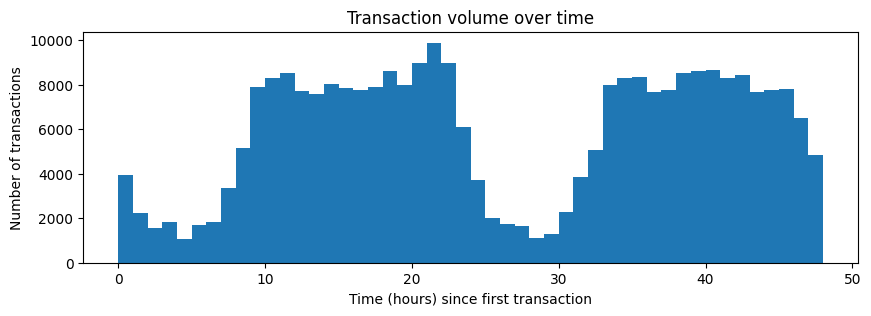

In [19]:
plt.figure(figsize= (10, 3))
plt.hist(time_hours, bins=48)
plt.xlabel('Time (hours) since first transaction')
plt.ylabel( 'Number of transactions')
plt.title('Transaction volume over time')
plt.show()

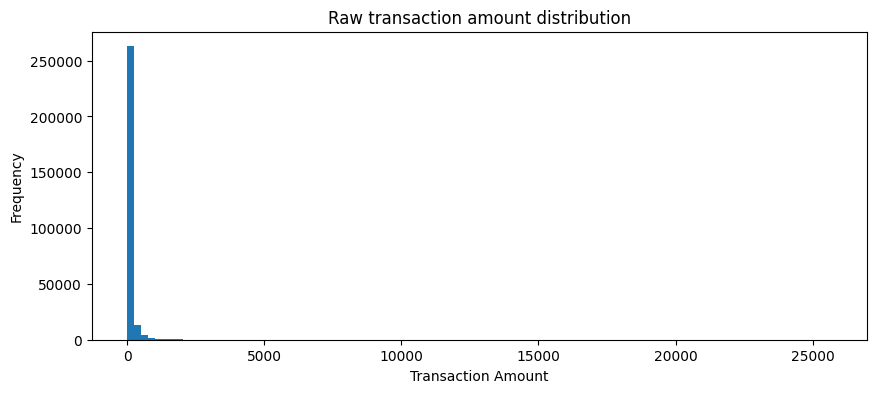

In [20]:
plt.figure(figsize=(10, 4))
plt.hist(X["Amount"], bins=100)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.title("Raw transaction amount distribution")
plt.show()

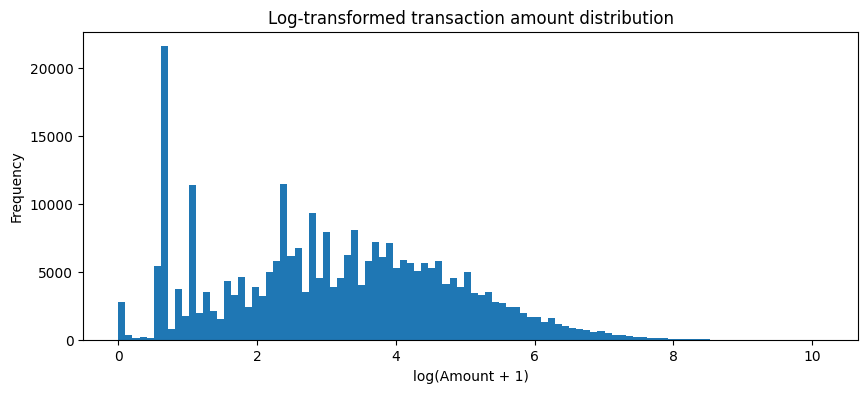

In [21]:
log_amount = np.log1p(X["Amount"])

plt.figure(figsize=(10, 4))
plt.hist(log_amount, bins=100)
plt.xlabel("log(Amount + 1)")
plt.ylabel("Frequency")
plt.title("Log-transformed transaction amount distribution")
plt.show()


In [22]:
X_sorted = X.sort_values(by= 'Time').reset_index(drop=True)
y_sorted = y_hidden.loc[X_sorted.index].reset_index(drop=True)

split_ratio = 0.7
split_index = int(len(X_sorted) * split_ratio)

X_train = X_sorted.iloc[:split_index]
X_test = X_sorted.iloc[split_index:]

y_train_hidden = y_sorted.iloc[:split_index]
y_test_hidden = y_sorted.iloc[split_index:]

print("Training set shape:", X_sorted.shape)
print("Test set shape:", X_test.shape)
print("Train time range:", X_train['Time'].min(), 'to', X_train['Time'].max())
print("Test time range:", X_test['Time'].min(), 'to', X_test['Time'].max())

Training set shape: (284807, 30)
Test set shape: (85443, 30)
Train time range: 0.0 to 132928.0
Test time range: 132929.0 to 172792.0


Given the sequential nature of the data and non-uniform transaction volume over time, 
a time-based split was used to simulate real-world deployment. 
The model was trained on earlier transactions and evaluated on later ones

In [23]:
#Scaling

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns= feature_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns= feature_cols)

print('Scaled traing set shape:', X_train_scaled.shape)
print('Scaled test set shape:', X_test_scaled.shape)
print('Train medians after scaling (should be near 0):')
print(X_train_scaled.median().head())

Scaled traing set shape: (199364, 30)
Scaled test set shape: (85443, 30)
Train medians after scaling (should be near 0):
Time    0.000000e+00
V1      0.000000e+00
V2      5.083468e-18
V3      0.000000e+00
V4     -4.132568e-18
dtype: float64


Given the heavy-tailed distribution of transaction amounts, 
RobustScaler was used to reduce the influence of extreme values. 
The scaler was fit exclusively on training data and applied unchanged to test data to avoid information leakage.

In [24]:
#Isolation Forest

iso_forest = IsolationForest(
    n_estimators=100,
    max_samples='auto',
    contamination='auto',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [25]:
iso_forest.fit(X_train_scaled)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",'auto'
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",-1
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [26]:
train_scores = iso_forest.decision_function(X_train_scaled)
test_scores = iso_forest.decision_function(X_test_scaled)

print("Training scores summary:")
print(pd.Series(train_scores).describe())
print("Test scores summary:")
print(pd.Series(test_scores).describe())

Training scores summary:
count    199364.000000
mean          0.097145
std           0.043625
min          -0.246298
25%           0.078687
50%           0.105323
75%           0.127013
max           0.158961
dtype: float64
Test scores summary:
count    85443.000000
mean         0.078640
std          0.039335
min         -0.272361
25%          0.063412
50%          0.087210
75%          0.106019
max          0.134322
dtype: float64


In [29]:
# Implementing threshold

alert_rate = 0.01 # 1% most anomalous
threshold = np.percentile(train_scores, 100 * alert_rate)
print(f'Anomaly score threshold (1%):{threshold:.4f}')

y_test_pred = (test_scores < threshold).astype(int)

alert_count = y_test_pred.sum()
alert_fraction = alert_count / len(y_test_pred)

print(f'Number of alerts in test set: {alert_count}')
print(f'Alert fraction in test set: {alert_fraction:.4f}')


Anomaly score threshold (1%):-0.0706
Number of alerts in test set: 945
Alert fraction in test set: 0.0111


In [31]:
#Evaluation
cm = confusion_matrix(y_test_hidden, y_test_pred)
cm

array([[84445,   890],
       [   53,    55]])

In [32]:
print(classification_report(y_test_hidden, y_test_pred, digits=4))

              precision    recall  f1-score   support

           0     0.9994    0.9896    0.9944     85335
           1     0.0582    0.5093    0.1045       108

    accuracy                         0.9890     85443
   macro avg     0.5288    0.7494    0.5495     85443
weighted avg     0.9982    0.9890    0.9933     85443



In [33]:
precision, recall, thresholds_pr = precision_recall_curve(
    y_test_hidden,
    -test_scores  # negate because lower scores = more anomalous
)

auprc = average_precision_score(y_test_hidden, -test_scores)

print(f"AUPRC: {auprc:.4f}")

AUPRC: 0.0367


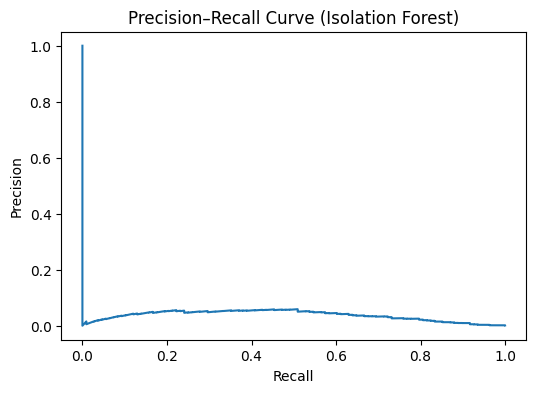

In [34]:
plt.figure(figsize=(6, 4))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Isolation Forest)")
plt.show()


In [ ]:
# The Isolation Forest model has been successfully implemented for credit card fraud detection. 
# The Isolation Forest, trained without labels, successfully identified approximately half of fraudulent transactions while flagging around 1% of total transactions as anomalous. 
# Although precision remains low due to the extreme class imbalance, the model achieves a substantial lift over random detection, 
# as reflected in an AUPRC significantly above the baseline fraud rate. This behavior is consistent with unsupervised anomaly detection, 
# where the model captures rare and unusual patterns rather than fraud specifically.

In [35]:
# Error Analysis

# Build a results DataFrame for analysis
results = X_test.copy()

results["anomaly_score"] = test_scores
results["predicted_anomaly"] = y_test_pred
results["actual_fraud"] = y_test_hidden.values

results.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,anomaly_score,predicted_anomaly,actual_fraud
199364,132929.0,-1.504565,-1.047164,2.658591,-0.246340,0.342667,0.182682,-0.424257,0.300896,0.638538,...,-0.048231,-0.437821,0.412388,-0.085327,-0.131134,-0.127378,118.58,0.089490,0,0
199365,132929.0,2.152590,-0.900447,-1.092456,-0.994969,-0.613447,-0.760012,-0.530218,-0.222248,-0.214416,...,0.358646,-0.782338,-0.480245,-0.647930,-0.023563,-0.044354,55.95,0.077973,0,0
199366,132929.0,1.811278,0.224393,0.542888,3.606222,-0.162910,1.171241,-0.874598,0.419449,-0.546470,...,0.365984,0.663253,-0.531272,-0.225013,0.032563,-0.022693,0.79,0.067160,0,0
199367,132929.0,-1.524832,-0.544095,-0.288824,-0.916791,3.524219,-1.830070,1.375925,-0.814647,-0.648070,...,-0.867245,0.838885,0.860487,-0.081074,-0.252743,-0.377957,30.90,0.045199,0,0
199368,132930.0,0.099135,0.873164,-0.362487,-0.612234,0.747229,-0.629384,0.755890,0.126794,-0.051667,...,0.115856,0.613080,-0.528392,0.092546,0.207960,0.071553,1.78,0.113186,0,0


In [36]:
# True Positives (caught fraud)
tp = results[(results["predicted_anomaly"] == 1) & (results["actual_fraud"] == 1)]

# False Positives (flagged but not fraud)
fp = results[(results["predicted_anomaly"] == 1) & (results["actual_fraud"] == 0)]

# False Negatives (missed fraud)
fn = results[(results["predicted_anomaly"] == 0) & (results["actual_fraud"] == 1)]

print("TP:", len(tp))
print("FP:", len(fp))
print("FN:", len(fn))

TP: 55
FP: 890
FN: 53


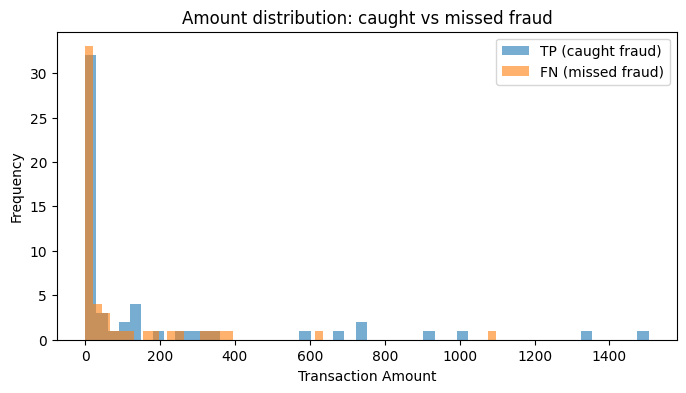

In [37]:
plt.figure(figsize=(8, 4))
plt.hist(tp["Amount"], bins=50, alpha=0.6, label="TP (caught fraud)")
plt.hist(fn["Amount"], bins=50, alpha=0.6, label="FN (missed fraud)")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.legend()
plt.title("Amount distribution: caught vs missed fraud")
plt.show()

In [ ]:
#The model tends to catch higher-amount frauds more reliably, , while low-value fraud often appears statistically normal and is therefore missed.

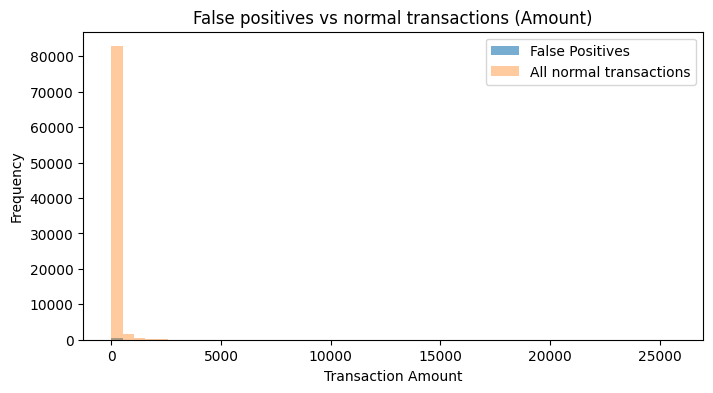

In [38]:
plt.figure(figsize=(8, 4))
plt.hist(fp["Amount"], bins=50, alpha=0.6, label="False Positives")
plt.hist(
    results[results["actual_fraud"] == 0]["Amount"],
    bins=50,
    alpha=0.4,
    label="All normal transactions"
)
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.legend()
plt.title("False positives vs normal transactions (Amount)")
plt.show()


In [ ]:
#False positives are dominated by low-value transactions.

TP score quantiles:
p01   -0.148324
p05   -0.128172
p10   -0.120509
p25   -0.109531
p50   -0.090382
p75   -0.080436
Name: anomaly_score, dtype: float64

FP score quantiles:
p01   -0.233527
p05   -0.186860
p10   -0.159691
p25   -0.123269
p50   -0.097389
p75   -0.083301
Name: anomaly_score, dtype: float64

Means:
TP mean: -0.09644207855610838
FP mean: -0.10883060751107804


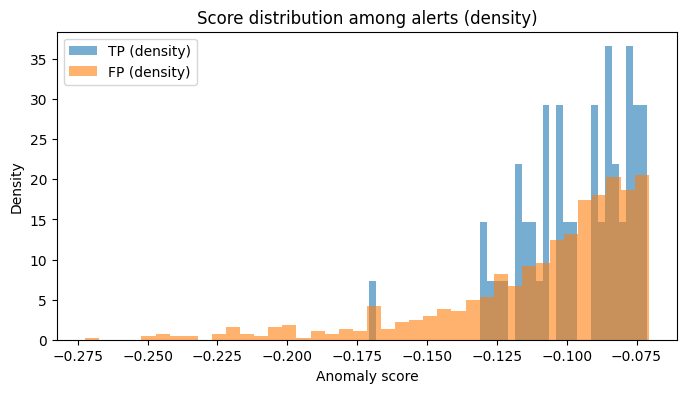

In [ ]:
tp_scores = tp["anomaly_score"]
fp_scores = fp["anomaly_score"]

def q(s):
    return s.quantile([0.01, 0.05, 0.10, 0.25, 0.50, 0.75]).rename({
        0.01:"p01", 0.05:"p05", 0.10:"p10", 0.25:"p25", 0.50:"p50", 0.75:"p75"
    })

print("TP score quantiles:")
print(q(tp_scores))
print("\nFP score quantiles:")
print(q(fp_scores))

print("\nMeans:")
print("TP mean:", tp_scores.mean())
print("FP mean:", fp_scores.mean())


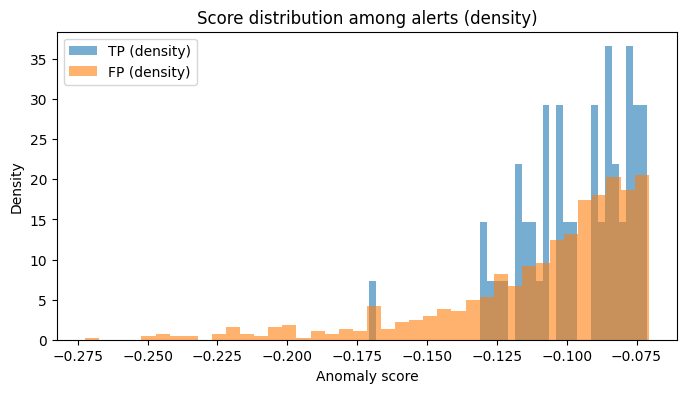

In [44]:
plt.figure(figsize=(8,4))
plt.hist(tp_scores, bins=40, density=True, alpha=0.6, label="TP (density)")
plt.hist(fp_scores, bins=40, density=True, alpha=0.6, label="FP (density)")
plt.xlabel("Anomaly score")
plt.ylabel("Density")
plt.title("Score distribution among alerts (density)")
plt.legend()
plt.show()


In [ ]:
#Among flagged alerts, non-fraud transactions exhibit more extreme anomaly scores than fraud cases. 
# False positives dominate the extreme left tail of the score distribution, while true fraud cases tend to be moderately anomalous rather than extreme. 
# This indicates that extreme rarity in feature space does not uniquely correspond to fraud, and that many fraudulent transactions closely resemble normal behavior. 
# Consequently, anomaly score magnitude alone is insufficient to distinguish fraud from other rare but legitimate patterns.

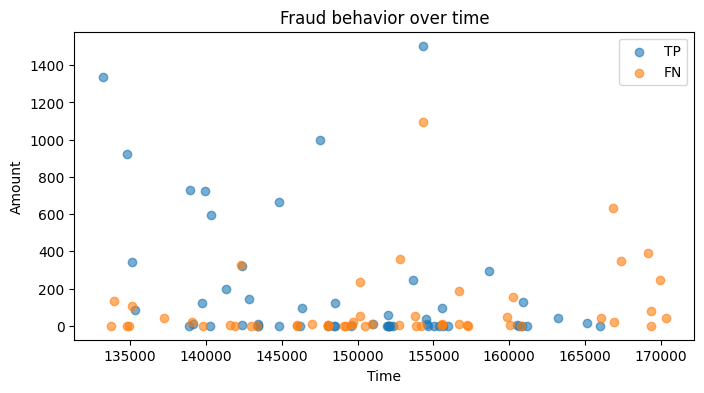

In [40]:
plt.figure(figsize=(8, 4))
plt.scatter(tp["Time"], tp["Amount"], alpha=0.6, label="TP")
plt.scatter(fn["Time"], fn["Amount"], alpha=0.6, label="FN")
plt.xlabel("Time")
plt.ylabel("Amount")
plt.legend()
plt.title("Fraud behavior over time")
plt.show()


In [ ]:
#Fraudulent transactions occur throughout the evaluation period, with no strong temporal clustering, 
# indicating that anomaly detection performance is driven primarily by feature-space rarity rather than timing effects.

In [ ]:
'''

Conclusion
1. Unsupervised anomaly detection captures fraud as a subset of rare behavior

The Isolation Forest, trained without labels, successfully identifies approximately half of fraudulent transactions. 
This indicates that a meaningful portion of fraud manifests as statistically unusual behavior relative to the broader transaction population. 
However, fraud does not constitute the most extreme anomalies in feature space.

2. Extreme anomalies are often legitimate transactions
Error analysis shows that false positives dominate the extreme left tail of the anomaly score distribution. 
Many legitimate transactions exhibit more extreme anomaly scores than actual fraud cases. 
This confirms that rarity does not imply fraud, and that unsupervised anomaly detection primarily identifies unusual structure rather than malicious intent.

3. Fraud tends to be moderately anomalous, not extreme
True fraud cases cluster closer to the anomaly threshold rather than at the most extreme scores. 
This suggests that many fraudulent transactions closely resemble normal behavior, particularly at low transaction amounts, 
which limits recall and precision when using anomaly detection alone.

4. Transaction amount influences detectability but is not decisive
Higher-value fraud is more likely to be detected, while low-amount fraud frequently blends into dense regions of normal behavior and is missed. 
However, false positives also concentrate heavily at low transaction amounts, 
indicating that amount alone does not separate fraud from non-fraud.

5. Anomaly scores are informative but not sufficient
Although anomaly score magnitude does not cleanly separate fraud from non-fraud, 
it provides useful ranking information. This supports the use of anomaly detection 
as a prioritization or filtering mechanism, rather than a standalone decision system.

'''